In [2]:
import pandas as pd
import numpy as np
import re, string
from os import path, getcwd, makedirs
from collections import defaultdict
from datetime import datetime
import pickle
import matplotlib.pyplot as plt


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

from sklearn import model_selection, naive_bayes, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_predict

import validators
import nltk
from info_gain.info_gain import info_gain_ratio
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression


In [3]:
import csv
fdir = path.join(getcwd(), "2019S1-proj2-datah")

train_data = "train-raw.tsv"
test_data = "test-raw.tsv"
dev_data = "dev-raw.tsv"

train_fpath = path.join(fdir, train_data)
test_fpath = path.join(fdir, test_data)
dev_fpath = path.join(fdir, dev_data)

train = pd.read_csv(train_fpath, encoding="utf_8", delimiter="\t", index_col="Instance_ID",  quoting=csv.QUOTE_NONE, error_bad_lines=False)
test = pd.read_csv(test_fpath, encoding="utf_8", delimiter="\t" , index_col="Instance_ID", quoting=csv.QUOTE_NONE, error_bad_lines=False)
dev = pd.read_csv(dev_fpath, encoding="utf_8", delimiter="\t" , index_col="Instance_ID")

In [4]:
inputs = 'Text'
output = 'Location'
x_train = train[inputs]
y_train = train[output]
x_test = test[inputs]
y_test = test[output]
x_dev = dev[inputs]
y_dev = dev[output]

In [7]:
class GeoTagger:
    _FEATURE_SELECTION = ["baseline_10", "baseline_50", "baseline_100", "info_gain_ratio", "word_locality_heuristic", "tf_idf"]
    _ENSEMBLE_STRATEGY = ["simple_voting", "meta_classification", "bagging", "random_forest", "boosting"]
    _CLASSIFIERS = ["Zero-R", "One-R", "Decision-Tree", "MultinomialNB", "LinearSVM", "SemiSupervised"]
    _EVALUATION_METRIC = ["accuracy", "precision_recall_f-score_with_macro", "precision_recall_f-score_with_micro"]
    
    def __init__(self, inputs, target, classifier_set=["MultinomialNB"], ensemble_strategy="simple_voting", feature_selection_method="baseline_100", seed=500, combine_classifiers=False, n_features=400):
        self.n_features = n_features
        self.inputs = inputs
        self.target = target
        self.classifier_set = classifier_set
        self.ensemble_strategy = ensemble_strategy
        self.feature_selection_method = feature_selection_method
        self.seed = seed
        np.random.seed(seed)
        self.stemmer = SnowballStemmer('english')
        self.stop_words = set(stopwords.words('english'))
        self.combine_classifiers = combine_classifiers
        self.classifier_set = self._generate_classifier_set(classifier_set)
        self.combined_classifier = None if not self.combine_classifiers else self.generate_ensemble_classifier()

    def train(self, X, y):
        """
        trains a classifier given the training data and their corresponding class labels
        """
        self.classes = list(y.unique())
        X = self.preprocess(X, y, train=True)

        if self.combine_classifiers:
            self.combined_classifier.fit(X, y)
            self.save_model(self.ensemble_strategy, self.combined_classifier)
        else:
            for name, classifier in self.classifier_set.items():
                classifier.fit(X, y)
                self.save_model(name, classifier)   

    def predict(self, X, load_model=False):
        """
        predicts a set of classifiers given some development data
        """
        X = self.preprocess(X)
        
        if self.combine_classifiers:
            return self.ensemble_predict(X, load_model)
        else:
            return self.base_predict(X, load_model)
        
    
    def evaluate(self, ybar, y):
        """
        evaluates a class' predictions given the correct class labels and an evaluation metric
        """
#         if not metric in GeoTagger._EVALUATION_METRIC:
#             print("Invalid Evaluation Metric: {}. Choose one of \
#             ({})".format(metric, ", ".join(GeoTagger._EVALUATION_METRIC)))
#             return
            
        score_set = defaultdict()
        confusions = defaultdict()
        
        if self.combine_classifiers:
            classifiers = [self.ensemble_strategy, ]
            ybar = pd.DataFrame(ybar, columns=classifiers, index = y.index)
        else:
            classifiers = self.classifier_set

        for name, y_pred in ybar.items():
            accuracy = accuracy_score(y, y_pred)
            score_set[name] = accuracy 
#             report = classification_report(ybar, y)
            confusions[name] = confusion_matrix(y, y_pred)

        return score_set, confusions

    def base_predict(self, X, load_model=False):
        y_set = pd.DataFrame()

        for name, classifier in self.classifier_set.items():
            if load_model:
                classifier = self.load_model(name)
            classifier_prediction = classifier.predict(X)
            y_set[name] = classifier_prediction
                
        return y_set
    
    def ensemble_predict(self, X, load_model=False):
        if load_model:
            self.combined_classifier = self.load_model(self.ensemble_strategy)
        
        return self.combined_classifier.predict(X, load_model)
    
    
    def preprocess(self, X, y=None, train=False):
        """
         - Filter rare words (urls, typos rare names, punctuation symbols)
         - calculate word frequencies 
         - metadata
        """
        X = self.filter(X)

        if train:
            self.feature_selection(X, y)
        
        X = self.bag_of_words(X)
            
        return X 
    
    def bag_of_words(self, X):
        _x = pd.DataFrame(
            [[(word in text) for word in sorted(list(self.features))] for text in X.values],
            index=X.index, 
            columns=self.features,
            dtype=np.uint8
        )        
        return _x
    
    def generate_ensemble_classifier(self):
        if not self.combine_classifiers:
            return None
        
        if not self.ensemble_strategy in GeoTagger._ENSEMBLE_STRATEGY:
            print("Invalid Ensemble Strategy Metric: {}. Choose one of \
            ({})".format(metric, ", ".join(GeoTagger._ENSEMBLE_STRATEGY)))
            return None
        
        if self.ensemble_strategy == "simple_voting":
            combined_classifier = VotingClassifier(self.classifier_set.items(), 'hard')
        elif self.ensemble_strategy == "meta_classification":
            combined_classifier = MetaClassifier(self.classifier_set.items(), self.seed)
        elif self.ensemble_strategy == "bagging":
            base_classifier = DecisionTreeClassifier(max_features=None, max_leaf_nodes=999)
            combined_classifier = BaggingClassifier(base_estimator=base_classifier, max_features=self.n_features, random_state=self.seed)
        elif self.ensemble_strategy == "random_forest":
            combined_classifier = RandomForestClassifier()
        elif self.ensemble_strategy == "boosting":
            combined_classifier = GradientBoostingClassifier()
        
        return combined_classifier
        
    
    def _generate_classifier_set(self, classifiers):
        classifier_set = defaultdict()
        
        for classifier in classifiers:
            if not classifier in GeoTagger._CLASSIFIERS:
                print("Invalid Classifier: {}. Choose one of \
                ({})".format(classifier, ", ".join(GeoTagger._CLASSIFIERS)))
                continue
                
            if classifier == "Zero-R":
                classifier_set[classifier] = DummyClassifier(strategy='most_frequent', random_state=self.seed)
            elif classifier == "One-R":
                classifier_set[classifier] = DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=self.seed)
            elif classifier == "Decision-Tree":
                classifier_set[classifier] = DecisionTreeClassifier(max_depth=None, criterion="entropy", random_state=self.seed)
            elif classifier == "MultinomialNB":
                classifier_set[classifier] = MultinomialNB()
            elif classifier == "LinearSVM":
                classifier_set[classifier] = svm.LinearSVC(random_state=self.seed)
            elif classifier == "SemiSupervised":
                classifier_set[classifier] = LabelSpreading(kernel="knn", n_neighbors=7, alpha=0.2)
        return classifier_set
                
    def feature_selection(self, X, y):
        """
        (1) Information Gain Ratio (IGR) - across all states S, is 
            defined as the ratio between its information gain value IG, 
            which measures the decrease in class entropy H that w brings,
            and its intrinsic entropy IV, which measures the entropy of 
            the presence versus the absence of that word
            
        (2) Word Locality Heuristic (WLH) - promotes words primarily 
            associated with one location. measure the probability of 
            a word occurring in a state, divided by its probability to 
            appear in any state. Then, for a given word w, we define the 
            WLH as the maximum such probability across all the states S
        """
        if self.feature_selection_method not in GeoTagger._FEATURE_SELECTION:
            print("Invalid Feature Selection method: {}. Choose one of \
            ({})".format(self.feature_selection_method, ", ".join(GeoTagger._FEATURE_SELECTION)))
            return 
        
        if self.feature_selection_method == "baseline_10":
            self.baseline_heuristic(X, y, "10")
        elif self.feature_selection_method == "baseline_50":
            self.baseline_heuristic(X, y, "50")
        elif self.feature_selection_method == "baseline_100":
            self.baseline_heuristic(X, y, "100")
        elif self.feature_selection_method == "info_gain_ratio":
#             self.information_gain_ratio(x)
            return
        elif self.feature_selection_method == "word_locality_heuristic":
            self.word_locality_weight(X, y)
        elif self.feature_selection_method == "tf_idf":
            self.term_frequency_inverse_city_frequency(X, y)

    def baseline_heuristic(self, X, y, top_n):
        feature_fpath = path.join(fdir, "train-top" + top_n + ".csv")
        
        if not path.exists(feature_fpath):
            print("Baseline Heuristic path {} does not exist".format(feature_fpath))
            return
        
        features = open(feature_fpath).readline()
        features = features.split(",")
        features.remove("Instance_ID")
        features.remove("Location\n")
        self.features = set(features)

    def word_locality_weight(self, X, y):
        """
        calculate frequencies of data 
        Measure frequency and divide by sum of freqencies of all words
        """
        locations = [location for location in self.classes]
        locations.append('Total')
        word_locality_features = {label: defaultdict(int) for label in locations}
        word_locality_weight = defaultdict(lambda: defaultdict(int))

        for x_i, y_i in zip(X.index, y.index):
            text = X.loc[x_i].split()
            for word in text:
                word_locality_features[y.loc[y_i]][word] += 1
                word_locality_features[y.loc[y_i]]['Total'] += 1
                word_locality_features['Total'][word] += 1
                word_locality_features['Total']['Total'] += 1

        for location in self.classes:
            for word in word_locality_features[location].keys():
    #                 if not word_locality_weight.get(word):
    #                     word_locality_weight[word] = defaultdict(int)

                cond_word_prob = word_locality_features[location][word] / word_locality_features[location]['Total']
                word_prob = word_locality_features['Total'][word] / word_locality_features['Total']['Total']
                word_locality_weight[word][location] = cond_word_prob / word_prob

        features = []
        for word in word_locality_weight:
            max_score = max(word_locality_weight[word].items(), key=lambda item:item[1])[1]
            features.append((word, max_score))
            n_location_features = int(self.n_features / len(self.classes))

        features = sorted(features, key=lambda kv: kv[1], reverse=True)[:self.n_features] 

        self.features = set([feature[0] for feature in features])
        print(sorted(list(self.features)))
                
    
    def information_gain_ratio(self, x):
#         return info_gain_ratio
        pass
    
    def term_frequency_inverse_city_frequency(self, X, y):
        vectorizer = TfidfVectorizer(stop_words=self.stop_words, max_features=self.n_features)

        location_word_list = {label: '' for label in self.classes}

        for x_i, y_i in zip(X.index, y.index):
            location_word_list[y.loc[y_i]] += X.loc[x_i] + " "
        
        labels = location_word_list.keys()
        corpus = location_word_list.values()
        vectorizer.fit(corpus, labels)
        self.features = set(vectorizer.get_feature_names())
        
    def filter(self, x):
        return x.apply(self.filter_text)
    
    def filter_text(self, text):
        return ' '.join(self.filter_word(w) for w in text.split())
        
    def filter_word(self, word):
        word = word.lower()
        # extract keywords from hashtag 

        if self._is_hyperlink(word):
            return ''
        elif self._is_hashtag(word):
            word = self._process_hashtag(word)
        # potentially cross-reference individuals mentioned? or discard
        elif self._is_mention(word):
            word = self._process_mention(word)
        # remove ascii characters 
        else:
            word = self._ascii_to_unicode(word)
            
            word = re.sub(r'[^\w\s]',' ', word)
#             word = self._word_stem(word)
            if word in self.stop_words:
                return ''
        return word
                
    def _is_hashtag(self, word):
        if len(word) == 0:
            return False
        return word[0] == "#"
    
    def _is_mention(self, word):
        if len(word) == 0:
            return False
        return word[0] == "@"
    
    def _is_hyperlink(self, word):
        return validators.url(word)
    
    def _process_hashtag(self, word):
        return word[1:]
    
    def _process_mention(self, word):
        return word[1:]
    
    def _ascii_to_unicode(self, word):
        for uescape in re.findall(r'(\\u[0-9a-f]{4})', word):
            try:
                word = word.replace(uescape, '')  
            except (UnicodeDecodeError, Exception):
                print("Failed to decode: {}".format(uescape))
        return word
    
    def _word_stem(self, word):
        return self.stemmer.stem(word)
    
    def save_model(self, name, model):
        dir_path = path.join(getcwd(), "models", self.feature_selection_method)
        model_fpath = path.join(dir_path, name + ".pkl")
        
        if not path.exists(dir_path):
            makedirs(dir_path)
            
        pickle.dump(model, open(model_fpath, 'wb'))
        
    def load_model(self, name):
        dir_path = path.join(getcwd(), "models", self.feature_selection_method)
        model_fpath = path.join(dir_path, name + ".pkl")
        
        with open(model_fpath, 'rb') as model_pickle:
            model = pickle.load(model_pickle)
        return model

In [8]:
class MetaClassifier:
    def __init__(self, estimators, random_state):
        self.estimators = estimators
        self.encoder = LabelEncoder()
        self.random_state = random_state
        self.meta_classifier = LogisticRegression(random_state=self.random_state, solver='lbfgs',multi_class='multinomial')
        np.random.seed(random_state)
    
    def fit(self, X, y):
        #y_set = pd.DataFrame(index=X.index, columns=[item[0] for item in self.estimators])
        
        MNB_meta = []
        SVM_meta = []
        DT_meta = []
        skf = KFold(10, False)
        num = 0
        for train, test in skf.split(X, y):
            for name, classifier in self.estimators:
                y_val = y[train].tolist()
                if name == "Decision-Tree":
                    print("DT")
                    print(train)
                    clf = DecisionTreeClassifier(max_depth=None, criterion="entropy", random_state=self.random_state)
                    clf.fit(X.iloc[train], y_val)
                    DT_meta+= clf.predict(X.iloc[test]).tolist()
                elif name == "MultinomialNB":
                    print("MNB")
                    print(train)
                    clf = MultinomialNB()
                    clf.fit(X.iloc[train], y_val)
                    MNB_meta+= clf.predict(X.iloc[test]).tolist()
                elif name == "LinearSVM":
                    print("LinearSVM")
                    print(train)
                    clf = svm.LinearSVC(random_state=self.random_state)
                    clf.fit(X.iloc[train], y_val)
                    SVM_meta+= clf.predict(X.iloc[test]).tolist()
                elif name == "One-R":
                    clf = DecisionTreeClassifier(max_depth=1, criterion="entropy", random_state=self.random_state)
                    clf.fit(X.iloc[train], y_val)
                    SVM_meta+= clf.predict(X.iloc[test]).tolist()
            num+=1
            print(num)

        #make dataframe m1,m2,m3 on metas
        d = {}
        for name, classifier in self.estimators:
            if name=="Decision-Tree":
                d["Decision-Tree-Metas"] = DT_meta
            elif name=="MultinomialNB":
                d["MultinomialNB-Metas"] = MNB_meta
            elif name=="LinearSVM":
                d["LinearSVM-Metas"] = SVM_meta
        train_meta = pd.DataFrame(d)
        
        encoded_train = pd.DataFrame(self.encoder.fit_transform(train_meta.values.ravel()).reshape(train_meta.shape))
        self.meta_classifier.fit(encoded_train, y)
        
        self.x_train = X
        self.y_train = y
        
    def predict(self, X):
        d = {} 
        #train entire X on all relevant classifiers
        for name, classifier in self.estimators:
            classifier.fit(self.x_train, self.y_train)
            d[name] = classifier.predict(X)
        test_meta = pd.DataFrame(d)
        print(test_meta)
        encoded_test = pd.DataFrame(self.encoder.fit_transform(test_meta.values.ravel()).reshape(test_meta.shape))
        return  self.meta_classifier.predict(encoded_test)

In [9]:
classifier_set = ["One-R", "MultinomialNB", "LinearSVM", "Decision-Tree"]
print(classifier_set)
voting_strategy = "meta_classification"
combine_classifiers = False

gt = GeoTagger(
    inputs = inputs,
    target = output,
    classifier_set = classifier_set,
    ensemble_strategy = voting_strategy,
    feature_selection_method = "tf_idf",
    n_features = 400,
    seed = 500,
    combine_classifiers = combine_classifiers
)

start = datetime.now()
gt.train(x_train, y_train)
end = datetime.now()
print("Time taken: {}".format(end - start))

gt2 = GeoTagger(
    inputs = inputs,
    target = output,
    classifier_set = classifier_set,
    ensemble_strategy = voting_strategy,
    feature_selection_method = "baseline_10",
    n_features = 34,
    seed = 500,
    combine_classifiers = combine_classifiers
)

start = datetime.now()
gt2.train(x_train, y_train)
end = datetime.now()
print("Time taken: {}".format(end - start))

gt3 = GeoTagger(
    inputs = inputs,
    target = output,
    classifier_set = classifier_set,
    ensemble_strategy = voting_strategy,
    feature_selection_method = "baseline_50",
    n_features = 185,
    seed = 500,
    combine_classifiers = combine_classifiers
)

start = datetime.now()
gt3.train(x_train, y_train)
end = datetime.now()
print("Time taken: {}".format(end - start))

gt4 = GeoTagger(
    inputs = inputs,
    target = output,
    classifier_set = classifier_set,
    ensemble_strategy = voting_strategy,
    feature_selection_method = "baseline_100",
    n_features = 366,
    seed = 500,
     combine_classifiers = combine_classifiers
)

start = datetime.now()
gt4.train(x_train, y_train)
end = datetime.now()
print("Time taken: {}".format(end - start))

# MNB = GeoTagger(
#     inputs = inputs,
#     target = output,
#     classifier_set = ["MultinomialNB"],
#     ensemble_strategy = voting_strategy,
#     feature_selection_method = "baseline_100",
#     n_features = 366,
#     seed = 500,
#     combine_classifiers = combine_classifiers
# )

# start = datetime.now()
# MNB.train(x_train, y_train)
# end = datetime.now()
# print("Time taken: {}".format(end - start))

# LSVM = GeoTagger(
#     inputs = inputs,
#     target = output,
#     classifier_set = ["LinearSVM"],
#     ensemble_strategy = voting_strategy,
#     feature_selection_method = "baseline_100",
#     n_features = 366,
#     seed = 500,
#     combine_classifiers = False
# )

# start = datetime.now()
# LSVM.train(x_train, y_train)
# end = datetime.now()
# print("Time taken: {}".format(end - start))


# DT = GeoTagger(
#     inputs = inputs,
#     target = output,
#     classifier_set = ["Decision-Tree"],
#     ensemble_strategy = voting_strategy,
#     feature_selection_method = "baseline_100",
#     n_features = 366,
#     seed = 500,
#      combine_classifiers = False
# )

# start = datetime.now()
# DT.train(x_train, y_train)
# end = datetime.now()
# print("Time taken: {}".format(end - start))

['One-R', 'MultinomialNB', 'LinearSVM', 'Decision-Tree']
Time taken: 0:10:00.221861
Time taken: 0:02:47.789302
Time taken: 0:03:30.190350
Time taken: 0:04:47.849175


In [10]:
#predict the class labels of a set of test data
ybars = gt.predict(x_dev, True)
ybars2 = gt2.predict(x_dev, True)
ybars3 = gt3.predict(x_dev, True)
ybars4 = gt4.predict(x_dev, True)

# MNBbar = MNB.predict(x_dev)
# LSVMbar = LSVM.predict(x_dev)
# DTbar = DT.predict(x_dev)

In [11]:
# models = [gt, gt2, gt3, gt4]
# predictions = [ybars, ybars2, ybars3, ybars4]
# evals = ["accuracy", "precision_recall_f-score_with_micro"]

# for model, prediction in zip(models, predictions):
#     for method in evals:
#         report, confusion = model.evaluate(prediction, y_dev, method)
#         print("{}: {}".format(method, report, ))
accScores = gt.evaluate(ybars, y_dev)
# otherScores = gt.evaluate(ybars, y_dev, "precision_recall_f-score_with_micro")
accScores2 = gt2.evaluate(ybars2, y_dev)
# otherScores2 = gt2.evaluate(ybars2, y_dev, "precision_recall_f-score_with_micro")
accScores3 = gt3.evaluate(ybars3, y_dev)
# otherScores3 = gt3.evaluate(ybars3, y_dev, "precision_recall_f-score_with_micro")
accScores4 = gt4.evaluate(ybars4, y_dev)
# otherScores4 = gt4.evaluate(ybars4, y_dev, "precision_recall_f-score_with_micro")

In [12]:
print(accScores, accScores2, accScores3, accScores4)

(defaultdict(None, {'One-R': 0.2693029490616622, 'MultinomialNB': 0.3225469168900804, 'LinearSVM': 0.31820375335120643, 'Decision-Tree': 0.2893297587131367}), defaultdict(None, {'One-R': array([[9315,    0,    9,    0],
       [9314,    0,   11,    0],
       [8595,    0,  730,    0],
       [9320,    0,    6,    0]], dtype=int64), 'MultinomialNB': array([[3187, 2356, 1576, 2205],
       [2139, 3454, 1528, 2204],
       [2259, 2490, 2427, 2149],
       [2353, 2475, 1535, 2963]], dtype=int64), 'LinearSVM': array([[2711, 2058, 1207, 3348],
       [1800, 3140, 1208, 3177],
       [1841, 2131, 2029, 3324],
       [1952, 2202, 1183, 3989]], dtype=int64), 'Decision-Tree': array([[2674, 2179, 1854, 2617],
       [2237, 2627, 2071, 2390],
       [2172, 2216, 2458, 2479],
       [2290, 2159, 1844, 3033]], dtype=int64)})) (defaultdict(None, {'One-R': 0.2693029490616622, 'MultinomialNB': 0.31002680965147456, 'LinearSVM': 0.31549597855227884, 'Decision-Tree': 0.31536193029490617}), defaultdict(Non

In [13]:
print(np.unique(ybars['LinearSVM'], return_counts=True))
print(np.unique(ybars2['LinearSVM'], return_counts=True))
print(np.unique(ybars3['LinearSVM'], return_counts=True))
print(np.unique(ybars4['LinearSVM'], return_counts=True))

(array(['Brisbane', 'Melbourne', 'Perth', 'Sydney'], dtype=object), array([ 8304,  9531,  5627, 13838], dtype=int64))
(array(['Brisbane', 'Melbourne', 'Perth', 'Sydney'], dtype=object), array([ 2575, 27326,  5266,  2133], dtype=int64))
(array(['Brisbane', 'Melbourne', 'Perth', 'Sydney'], dtype=object), array([ 3141,  9815,  4389, 19955], dtype=int64))
(array(['Brisbane', 'Melbourne', 'Perth', 'Sydney'], dtype=object), array([ 6355,  9626,  3810, 17509], dtype=int64))


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[9.99034749e-01 0.00000000e+00 9.65250965e-04 0.00000000e+00]
 [9.98820375e-01 0.00000000e+00 1.17962466e-03 0.00000000e+00]
 [9.21715818e-01 0.00000000e+00 7.82841823e-02 0.00000000e+00]
 [9.99356637e-01 0.00000000e+00 6.43362642e-04 0.00000000e+00]]
Normalized confusion matrix
[[9.99034749e-01 0.00000000e+00 9.65250965e-04 0.00000000e+00]
 [9.98820375e-01 0.00000000e+00 1.17962466e-03 0.00000000e+00]
 [9.21715818e-01 0.00000000e+00 7.82841823e-02 0.00000000e+00]
 [9.99356637e-01 0.00000000e+00 6.43362642e-04 0.00000000e+00]]
Normalized confusion matrix
[[9.99034749e-01 0.00000000e+00 9.65250965e-04 0.00000000e+00]
 [9.98820375e-01 0.00000000e+00 1.17962466e-03 0.00000000e+00]
 [9.21715818e-01 0.00000000e+00 7.82841823e-02 0.00000000e+00]
 [9.99356637e-01 0.00000000e+00 6.43362642e-04 0.00000000e+00]]
Normalized confusion matrix
[[9.99034749e-01 0.00000000e+00 9.65250965e-04 0.00000000e+00]
 [9.98820375e-01 0.00000000e+00 1.17962466e-03 0.00000000e+00]
 [9

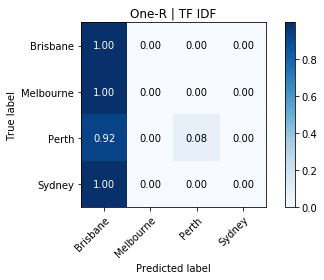

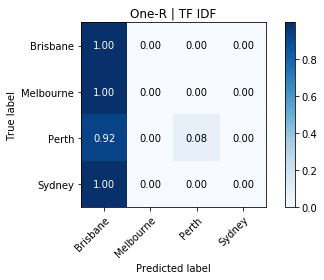

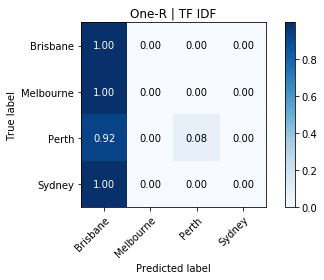

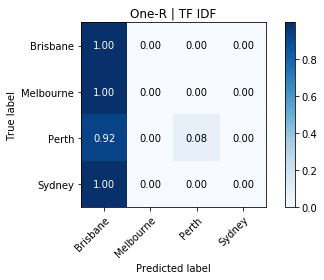

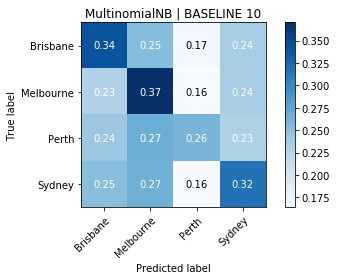

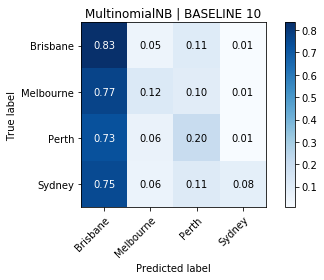

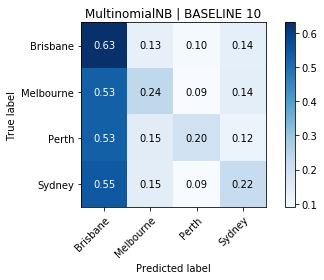

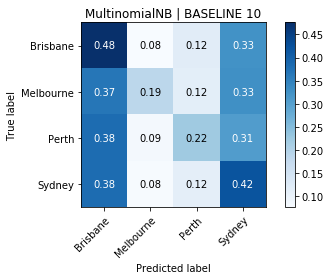

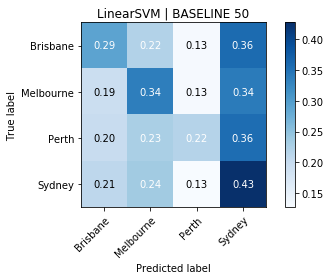

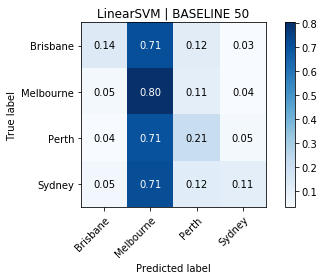

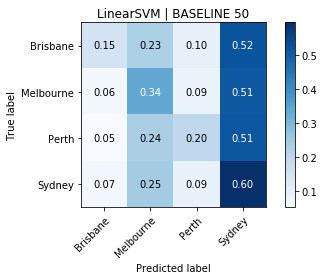

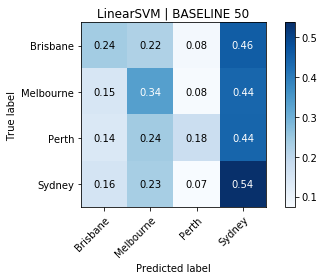

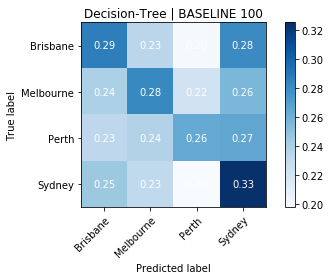

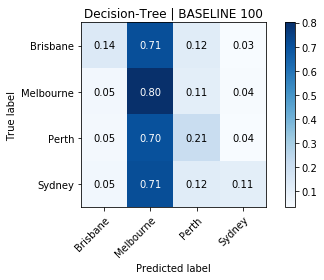

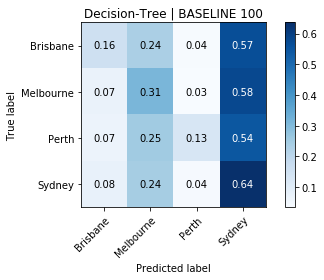

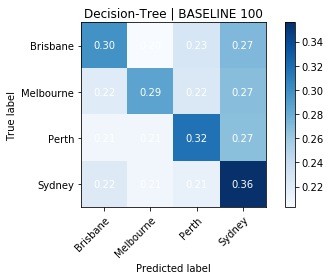

In [17]:
classes = np.unique(y_dev)
fs_set = ["TF IDF", "BASELINE 10", "BASELINE 50", "BASELINE 100"]
for cl, fs in zip(classifier_set, fs_set):
    plot_confusion_matrix(cm = accScores[1][cl], classes = classes, normalize=True, title = cl+ " | "+fs)
    plot_confusion_matrix(cm = accScores2[1][cl], classes = classes, normalize=True, title = cl+ " | "+fs)
    plot_confusion_matrix(cm = accScores3[1][cl], classes = classes, normalize=True, title = cl+ " | "+fs)
    plot_confusion_matrix(cm = accScores4[1][cl], classes = classes, normalize=True, title = cl+ " | "+fs)

### Some Resources
- https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
- http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

In [16]:
#testPreds = gt.predict(x_test)
#testPreds2 = gt2.predict(x_test)
#testPreds3 = gt3.predict(x_test)
#testPreds4 = gt4.predict(x_test)

In [139]:
#from pandas import Dataframe
testBagging100 = test.copy()
testBagging100[output] = testPreds4
testOutput = pd.DataFrame(testBagging100[output])
testOutput.columns = ['Class']
export_csv = testOutput.to_csv ('testBagging100.csv',index = True, header=True)

In [123]:
len(testPreds4)

108148

In [124]:
len(testOutput)

108148